# National health and Nutrition Examination Survey Predictive Modeling Project
## Following analysis is conducted on patient-level  data captured from various data files containing demographics, diet, medical examination, medication, labs and patient surveys. 
## A. My goal is to identify a reasonable, severe, and impactable Outcome Measure, and conduct my work to understand the contributing factors to that outcome. 
## B. I will also attempt to un-earth the underlying relationships between all variables using more advance machine learning methods




In [46]:
#importing various packages I expect to use
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import scipy 
import scipy.stats as stats

In [3]:
#importing all my data
import pandas as pd
demographics=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/demographic.csv",index_col='SEQN')
diet=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/diet.csv",index_col='SEQN')
examination=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/examination.csv',index_col='SEQN')
labs=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/labs.csv',index_col='SEQN')
medications=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/medications.csv",encoding='ISO-8859-1',index_col='SEQN')
questionnaire=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/SpringBoard/Capstone/national-health-and-nutrition-examination-survey/Data/questionnaire.csv',index_col='SEQN')

In [4]:
#converting my data into Pandas DataFrames
demographics = pd.DataFrame(demographics)
diet = pd.DataFrame(diet)
examination = pd.DataFrame(examination)
labs = pd.DataFrame(labs)
medications = pd.DataFrame(medications)
questionnaire = pd.DataFrame(questionnaire)

In [5]:
#Reviewed Med data, established RX Count as the only variable of interest, and adding it to the rest of my data
medications['SEQN']=medications.index
medications = medications[['SEQN','RXDCOUNT']]
medications = medications.drop_duplicates()
medications = medications[['RXDCOUNT']]
data = pd.concat([demographics,diet,examination,labs,questionnaire,medications], axis=1)

In [1]:
#Loading Variable Dictionary that I saved as JSON in another query
VariableDict = json.load(open('Variable-Dictionary.json'))

In [6]:
#getting info on my final dataframe to ensure it has all the expected rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10175 entries, 73557 to 83731
Columns: 1812 entries, SDDSRVYR to RXDCOUNT
dtypes: float64(1757), int64(24), object(31)
memory usage: 140.7+ MB


## We can see that the dataframe has roughly 10,000 members, and around 2,500 variables. 
### This poses a challenge in both seeing the content at a glance, as well as potential issues with modelig efforts such as colinearity. 
### I will attempt to reduce the number of variables using both clinical knowledge, and methods to examine each variable for correctness and relevance

In [7]:
# To best prepare my dataset for Machine Learning exercises, I want to have only boolean data for all my columns. 
#In roder to do this, I am expanding columns with categorial data into their own columns so I can have boolean data for them.
list_object = data.select_dtypes(include=[np.object])
data = pd.get_dummies(data, columns= list_object.columns)
data.info()
data.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10175 entries, 73557 to 83731
Columns: 2470 entries, SDDSRVYR to SMD100BR_WINSTON RED
dtypes: float64(1757), int64(24), uint8(689)
memory usage: 145.0 MB


## Exploratory Data Analysis

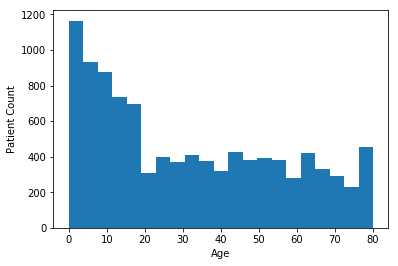

In [8]:
#Drawing age distribution for the population
plt.hist(data['RIDAGEYR'],bins='auto')
plt.xlabel('Age')
plt.ylabel('Patient Count')
plt.show()

## We can see a fairly uniform distribution across the adult population, and a large number of pediatrics relative to adults. It may be worth considering splitting outcomes more relevant to pediatric vs. adult populations

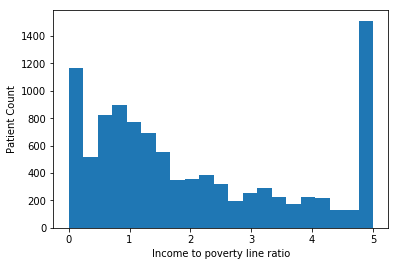

In [9]:
#Drawing distribution of ratio of income to poverty line for the population
plt.hist(data['INDFMPIR'],bins='auto')
plt.xlabel('Income to poverty line ratio')
plt.ylabel('Patient Count')
plt.show()

## There seems to be a fairly normal distribution of income/poverty ratio, if not for the tailing and limiting the numbers at each end. We will see if this variable will have any significance in our comparisons



## Reviewing the distribution of Asthma elements. The "ER Visits for Asthma" seems to be accurate from a clinical standpoint. 
## I  am assessing Asthma due to its prevalence to pediatric population

In [10]:
# Reviewing the distribution of Asthma elements. This one, the "ER Visits for Asthma" seems to be accurate from a clinical standpoint. 
# I  am assessing Asthma due to its prevalence to pediatric population
print('ER visits for Asthma:')
print(data['MCQ050'].value_counts())

ER visits for Asthma:
0.0    9236
2.0     745
1.0     193
9.0       1
Name: MCQ050, dtype: int64


In [11]:
len(data[data['MCQ050']>0])/len(data)

0.09228501228501229

## About 9%  of the population are shown to have Asthma related ER visits in the past

## My next inclination is to see the relationship between Age and Asthma to determine if it is more prevalent in children or adults. 

In [12]:
## Building new variables of age-bands 
# I am adding these elements in case they become significant in correlation or predictive models
data['=<18yrs']= (data['RIDAGEYR']<=18).astype(int)
data['18<yrs<=45']= ((data['RIDAGEYR']<=45) & (data['RIDAGEYR']>18 )).astype(int)
data['45<yrs<=65']= ((data['RIDAGEYR']<=65) & (data['RIDAGEYR']>45)).astype(int)
data['>65yrs']= (data['RIDAGEYR']>65).astype(int)

In [52]:
Peds = data[data['=<18yrs']==True]
Eighteento45 = data[data['18<yrs<=45']==True]
FortySixto65 = data[data['45<yrs<=65']==True]
Senior = data[data['>65yrs']==True]
PedsAsthmaRate=len(Peds[Peds['MCQ050']>0])/len(Peds)
PedsAsthmaData = Peds[Peds['MCQ050']>0].MCQ050
print(PedsAsthmaRate)
print(len(Eighteento45[Eighteento45['MCQ050']>0])/len(Eighteento45))
print(len(FortySixto65[FortySixto65['MCQ050']>0])/len(FortySixto65))
print(len(Senior[Senior['MCQ050']>0])/len(Senior))

0.09428638608041383
0.08375634517766498
0.10051546391752578
0.0915032679738562


## Hypothesis: Asthma Rate in Peds is not significantly different from Asthma Rate in the whole population

###

In [44]:
PopAsthmaRate = len(data[data['MCQ050']>0])/len(data)
print(PopAsthmaRate)

0.09228501228501229


In [54]:
stats.ttest_1samp(PedsAsthmaData, # Sample data
                 PopAsthmaRate)  # Pop Rate

Ttest_1sampResult(statistic=74.873698658448447, pvalue=2.0390929217290342e-237)

In [55]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=49)  # Degrees of freedom

-2.0095752344892093

In [56]:
stats.t.ppf(q=0.975,  # Quantile to check
            df=49)  # Degrees of freedom

2.0095752344892088

In [57]:
stats.t.cdf(x= -2.5742,      # T-test statistic
               df= 49) * 2   # Mupltiply by two for two tailed test*

0.013121066545690117

In [58]:
sigma = PedsAsthmaData.std()/math.sqrt(50)    # Sample stdev/sample size

stats.t.interval(0.95,                        # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = PedsAsthmaRate,        # Sample mean
                 scale= sigma)                # Standard dev estimate

NameError: name 'math' is not defined

In [ ]:
stats.t.interval(alpha = 0.99,                # Confidence level
                 df = 49,                     # Degrees of freedom
                 loc = PedsAsthmaRate,        # Sample mean
                 scale= sigma)                # Standard dev estimate

## For all age-bands, the ratio of Asthma ED visits seems to be similar. 

## Further studying variables and creating new ones:

In [ ]:
#Transforming data to make High BP Variables and BMI
data['HighBPSys'] = (data['BPXSY2']>=160).astype(int)
data['HighBPDia']= (data['BPXDI2']>=100).astype(int)
data['HighBMI'] = (data['BMXBMI']>25).astype(int)
# Twice the poverty line indicator
data['2xPovertyLine'] = (data['INDFMPIR']<2).astype(int)

In [14]:
print('High Blood Sugar in past 3 years:')
print(data['DIQ180'].value_counts())
len(data[data['DIQ180']>0])/len(data)

High Blood Sugar in past 3 years:
0.0    3706
2.0    3469
1.0    2842
9.0     158
Name: DIQ180, dtype: int64


0.6357739557739558

In [15]:
print('Illicit substances')
print(data['DUQ240'].value_counts())
len(data[data['DUQ240']>0])/len(data)

Illicit substances
0.0    5635
2.0    3800
1.0     723
7.0      10
9.0       7
Name: DUQ240, dtype: int64


0.4461916461916462

## Based on above numbers, 64% or patients have had high blood sugar, and 45% used illicit substances. 
## These results seem to high to be true, so I will omit these variables in the final model

## Studying correlation between variables:

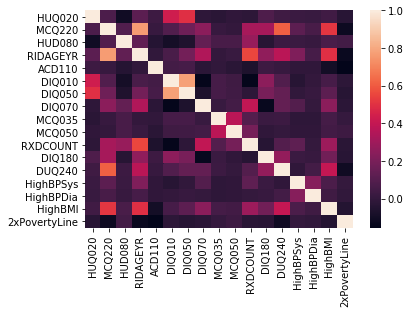

HUQ020: Compared with 12 months ago, would you say {your/SP's} health is now . . .
MCQ220: {Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had cancer or a malignancy (ma-lig-nan-see) of any kind?
HUD080: How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? (Do not count total number of nights, just total number of hospital admissions for stays which lasted 1 or more nights.)
RIDAGEYR: Age in years of the participant at the time of screening. Individuals 80 and over are topcoded at 80 years of age.
ACD110: {Do you/Does SP} speak only (NON-ENGLISH LANGUAGE), more (NON-ENGLISH LANGUAGE) than English, both equally, more English than (NON-ENGLISH LANGUAGE), or only English?
DIQ010: The next questions are about specific medical conditions. {Other than during pregnancy, {have you/has SP}/{Have you/Has SP}} ever been told by a doctor or health professional that {you have/{he/she/SP} has} diabetes o

KeyError: 'HighBPSys'

In [32]:
## Observing correlation between hand-picked clinically or socially significnat variables
VariableCorrelations = data[['HUQ020','MCQ220','HUD080','RIDAGEYR','ACD110','DIQ010','DIQ050','DIQ070','MCQ035','MCQ050','RXDCOUNT','DIQ180','DUQ240','HighBPSys','HighBPDia','HighBMI','2xPovertyLine']]
PearsonCorr = VariableCorrelations.corr(method='pearson')
sns.heatmap(PearsonCorr)
plt.show()
for var in VariableCorrelations:
    print('{}: {}'.format(var, VariableDict[var]))

## The following variables show relationships to each other:
### HUQ020 with DIQ010 and DIQ050
    ### current health with Diabetes indicators
### MCQ220 with Age and High BMI
    ### Cancer with Age and BMI
### RIDAGEYR with High BMI and RXDCOUNT
    ### Age with high BMI and increased Rx Count
### DIQ070 with RXDCOUNT
    ### Diabetic and Medication count
### DUQ240 with  MCQ220, RIDAGEYR, HighBMI
    ### Illicit substances with Age, High BMI and Cancer
### DIQ180 with  MCQ220
    ### High Blood Sugar with Cancer

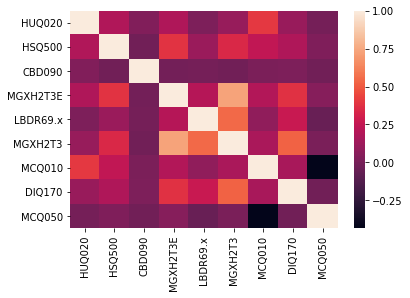

HUQ020: Compared with 12 months ago, would you say {your/SP's} health is now . . .
HSQ500: Did {you/SP} have a head cold or chest cold that started during those 30 days?
CBD090: About how much money was spent on nonfood items?
MGXH2T3E: Whether the participant exerted a maximal or questionable effort during the test 3 on hand 2, as assessed by the technician.
LBDR69.x: HPV linear array 69
MGXH2T3: Grip strength (kg), hand 2, test 3
MCQ010: The following questions are about different medical conditions. Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} asthma (az-ma)?
DIQ170: {Have you/Has SP} ever been told by a doctor or other health professional that {you have/s/he has} health conditions or a medical or family history that increases {your/his/her} risk for diabetes?
MCQ050: [During the past 12 months], {have you/has SP} had to visit an emergency room or urgent care center because of asthma (az-ma)?


In [29]:
# Further exploring clinically relevant variables
vars = ['HUQ020','HSQ500','CBD090','MGXH2T3E','LBDR69.x','MGXH2T3','MCQ010','DIQ170','MCQ050']
core_features = data[vars]
predmodelcorr = core_features.corr()
sns.heatmap(predmodelcorr)
plt.show()
for var in vars:
    print('{}: {}'.format(var, VariableDict[var]))

In [39]:
HUQ020Vars = ['HUQ020','MCQ220','HUD080','RIDAGEYR','ACD110','DIQ010','DIQ050','DIQ070','MCQ035','RXDCOUNT','DIQ180','DUQ240']
print('HUQ020 Pred Factors:')
for var in HUQ020Vars:
    print('{}: {}'.format(var, VariableDict[var]))

HUQ020 Pred Factors:
HUQ020: Compared with 12 months ago, would you say {your/SP's} health is now . . .
MCQ220: {Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had cancer or a malignancy (ma-lig-nan-see) of any kind?
HUD080: How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? (Do not count total number of nights, just total number of hospital admissions for stays which lasted 1 or more nights.)
RIDAGEYR: Age in years of the participant at the time of screening. Individuals 80 and over are topcoded at 80 years of age.
ACD110: {Do you/Does SP} speak only (NON-ENGLISH LANGUAGE), more (NON-ENGLISH LANGUAGE) than English, both equally, more English than (NON-ENGLISH LANGUAGE), or only English?
DIQ010: The next questions are about specific medical conditions. {Other than during pregnancy, {have you/has SP}/{Have you/Has SP}} ever been told by a doctor or health professional that {you have/{he/sh

## From a clinical and financial perspective, number of hospital admissions is an attractive outcoe metric to consider. Given I am not seeing many correlations with other consiered variables, I will explore relationship of different variables to this variable using other methods

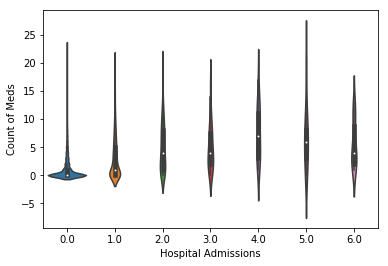

In [18]:
sns.violinplot(x='HUD080',y='RXDCOUNT',data=data)
plt.xlabel('Hospital Admissions')
plt.ylabel('Count of Meds')
plt.show()

### We can see above that the mean of the rx meds increases for people with more hospital admission.
### Below, we will use a boostrap hypothesis testing method to see if there is a positive correlation between Rx Count and Hospital Admissions

Slope and intercept: [ 1.40313303  1.20316972]


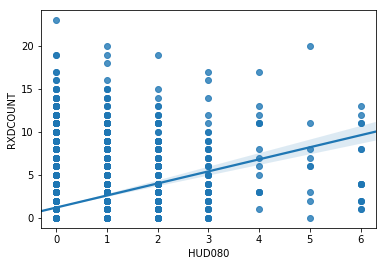

correlation and p-value : (0.28190003329023394, 3.4066139342273198e-185)


In [19]:
dataForBootstrap = data[['HUD080', 'RXDCOUNT']]
dataForBootstrap = dataForBootstrap.dropna(axis=0,how='any')
dataForBootstrap = dataForBootstrap.reset_index(drop=True)
Admissions = dataForBootstrap['HUD080']
MedsCount = dataForBootstrap['RXDCOUNT']
print('Slope and intercept:', np.polyfit(Admissions,MedsCount,1))
sns.regplot(x=Admissions, y=MedsCount, data=data)
plt.show()
print ('correlation and p-value :',scipy.stats.pearsonr(Admissions, MedsCount))

### We can show above that there is some correlation between Meds Count and Hospital Admissions, with a low p-value, establishing the correlation as statistically significant.

## Below we examine correlation between 'weird taste in mouth that will not go away' and Cancer. 
### We see a positive correlation and a 0 p-value, showing statisticaly significant between these factors

Slope and intercept: [ 0.61086838  0.06751309]


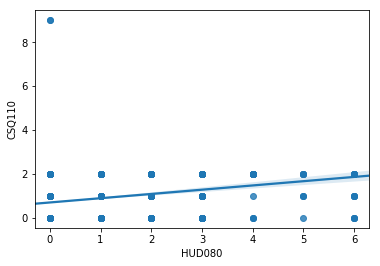

correlation and p-value : (0.6193739303665482, 0.0)


In [20]:
dataForBootstrap = data[['MCQ220', 'CSQ110']]
dataForBootstrap = dataForBootstrap.dropna(axis=0,how='any')
dataForBootstrap = dataForBootstrap.reset_index(drop=True)
Cancer = dataForBootstrap['MCQ220']
TasteMouth = dataForBootstrap['CSQ110']
print('Slope and intercept:', np.polyfit(Cancer,TasteMouth,1))
sns.regplot(x=Admissions, y=TasteMouth, data=data)
plt.show()
print ('correlation and p-value :',scipy.stats.pearsonr(Cancer, TasteMouth))

## We examine relationship between Hospital Admissions and Poverty, and find no correlation with significance.

Slope and intercept: [ 0.04931893  0.5752041 ]


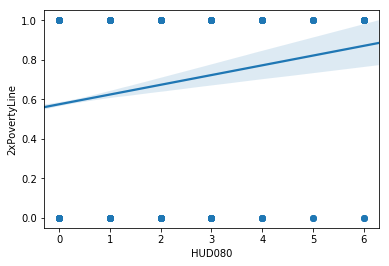

correlation and p-value : (0.050283086821118567, 3.8810269757071209e-07)


In [21]:
dataForBootstrap = data[['HUD080', '2xPovertyLine']]
dataForBootstrap = dataForBootstrap.dropna(axis=0,how='any')
dataForBootstrap = dataForBootstrap.reset_index(drop=True)
Admissions = dataForBootstrap['HUD080']
Poverty = dataForBootstrap['2xPovertyLine']
print('Slope and intercept:', np.polyfit(Admissions,Poverty,1))
sns.regplot(x=Admissions, y=Poverty, data=data)
plt.show()
print ('correlation and p-value :',scipy.stats.pearsonr(Admissions, Poverty))

## ------------------------------------------------
## To ensure comprehensiveness in approach, we review the distribution of a few different potential outcome metrics here:

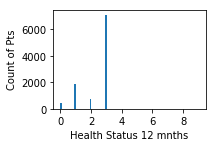

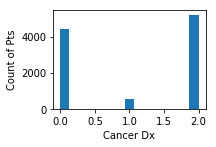

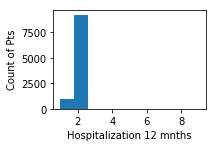

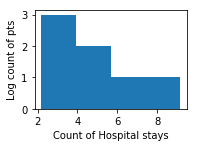

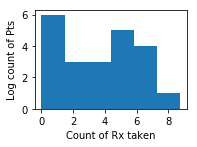

In [22]:
##Observating behavior of potential outcome variables
#Health Status
plt.subplot(2,2,1)
plt.hist(data['HUQ020'],bins='auto')
plt.xlabel('Health Status 12 mnths')
plt.ylabel('Count of Pts')
plt.show()
#Cancer any time in the past
plt.subplot(2,2,2)
plt.hist(data['MCQ220'],bins='auto')
plt.xlabel('Cancer Dx')
plt.ylabel('Count of Pts')
plt.show()
#Hospitalization over pas 12 mnths
plt.subplot(2,2,3)
plt.hist(data['HUQ071'],bins=10)
plt.xlabel('Hospitalization 12 mnths')
plt.ylabel('Count of Pts')
plt.show()
# Count of hospital stays
HUD080log = np.log(data['HUD080'].value_counts())
plt.subplot(2,2,4)
plt.hist(HUD080log,bins='auto')
plt.xlabel('Count of Hospital stays')
plt.ylabel('Log count of pts')
plt.show()
# Count of Drugs taken RXDCOUNT
RXDCOUNTlog = np.log(data['RXDCOUNT'].value_counts())
plt.subplot(2,2,4)
plt.hist(RXDCOUNTlog,bins='auto')
plt.xlabel('Count of Rx taken')
plt.ylabel('Log count of Pts')
plt.show()

## We can see above that some of the other proposed Outcome Variables lack the necessary distribution to be ideal candidates. This is in exception to the HUD080 (Number of Hospital stays) that does have a right-tailed distribution. 
## We will further analyze this metric below

In [23]:
len(data[data['HUD080']>=1])/len(data)

0.09110565110565111

### I am looking for a reasonable percentage of members in the outcome variable. In this case the 9% seems good
### I will establish this as my outcome variable below

In [24]:
data['HUD080Outcome'] = np.where(data['HUD080']>=1, 1, 0)

In [25]:
from sklearn.ensemble import RandomForestClassifier
#Load boston housing dataset as an example
#boston = load_boston()
#mention this as detour in EDA
X = data[data.columns.difference(['HUD080'])]
Y = data['HUD080Outcome']
names = data.columns
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X, Y)
print ("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Features sorted by their score:
[(0.30270000000000002, 'LBDR71.x'), (0.1105, 'LBDR89.x'), (0.0126, 'LBDR83.x'), (0.0044999999999999997, 'ORXH59'), (0.0035999999999999999, 'SXQ624'), (0.0035000000000000001, 'SXQ841'), (0.0035000000000000001, 'SXQ130'), (0.0033, 'SXQ600'), (0.0033, 'DLQ080'), (0.0032000000000000002, 'ACD011B'), (0.0025999999999999999, 'SXQ410'), (0.0025999999999999999, 'DMDHRBR4'), (0.0025999999999999999, 'CSXSOAOD'), (0.0025999999999999999, 'CSXSLTSG'), (0.0025000000000000001, 'LBDR42.y'), (0.0025000000000000001, 'ACD040'), (0.0023999999999999998, 'OHX02CTC_X'), (0.0023999999999999998, 'BMDBMIC'), (0.0023, 'OHX21SE'), (0.0022000000000000001, 'URXUMN'), (0.0022000000000000001, 'OHX15TC'), (0.0022000000000000001, 'DR1TVB6'), (0.0020999999999999999, 'URDUHGLC'), (0.0020999999999999999, 'SXQ251'), (0.0020999999999999999, 'OHX15SE'), (0.0020999999999999999, 'DRQSDT5'), (0.0020999999999999999, 'ALQ151'), (0.002, 'ORXH62'), (0.002, 'OHX10SE'), (0.002, 'OHX09CSC'), (0.002, 'LBD

NameError: name 'indices' is not defined

In [ ]:
# For Health Status : HUQ080
print('LBDR89.x :',VariableDict["LBDR89"])
print('LBDR71.x :',VariableDict["LBDR71.x"])
print('SXQ130 :',VariableDict["SXQ130"])
print('SXQ841 :',VariableDict["SXQ841"])
print('SXD450 :',VariableDict["SXD450"])
print('SXQ645 :',VariableDict["SXQ645"])
print('SXQ260 :',VariableDict["SXQ260"])
print('OHX30SE :',["Dental Sealants"])
print('CSXSBOD :',"Forced Odor Selection: Strawberry")
print('URXUSR :',VariableDict["URXUSR"])
print('LBDR33.y :',"more HPV")
print('OHX28TC :',"Tooth Count")
print('SMD100BR_VIRGINIA SLIMS SUPERSLIMS GOLD :',"SMD100BR_VIRGINIA SLIMS SUPERSLIMS GOLD")

## Given the high number of variables, I ran a few different models to find significant variables for various metrics. I will further analyze the correlation of these variables to each other below.

In [ ]:
# For Cancer Dx: MCQ220
print('CSQ140 :',VariableDict["CSQ140"])
print('PEASCCT1 :',VariableDict["PEASCCT1"])
print('CSQ160 :',VariableDict["CSQ160"])
print('CSQ120A :',VariableDict["CSQ120A"])
print('CSQ100 :',VariableDict["CSQ100"])
print('CDQ005 :',VariableDict["CDQ005"])
print('OHX21TC :',VariableDict["OHX21TC"])


In [ ]:
core_features = data[['HUQ020','HSQ500','CBD090','MGXH2T3E','LBDR69.x','MGXH2T3','MCQ010','DIQ170','MCQ050']]
predmodelcorr = core_features.corr()
sns.heatmap(predmodelcorr)
plt.show()
print('HUQ020 :',VariableDict["HUQ020"])
print('HSQ500 :',VariableDict["HSQ500"])
print('CBD090 :',VariableDict["CBD090"])
print('MGXH2T3E :',VariableDict["MGXH2T3E"])
print('LBDR69.x :',VariableDict["LBDR69.x"])
print('MGXH2T3 :',VariableDict["MGXH2T3"])
print('MCQ010 :',VariableDict["MCQ010"])
print('MCQ010 :',VariableDict["DIQ170"])
print('MCQ050 :',VariableDict["MCQ050"])

## There is decent correlation between many of the above variables. 
## I will apply additional modeling techniques to further discover relationships